In [42]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [43]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [44]:
def get_team_players(team):
    base_path = '//Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [45]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [46]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [47]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur']

In [48]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_initial_11(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
           
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [49]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [50]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [51]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [52]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,38.055556
"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,35.455556
"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,34.5
"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,27.288889
"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,26.5
...,...,...,...,...,...,...,...,...,...,...
"Dembele, Mousa",52.93458,0.91476,11.81214,0.03978,3.69936,1.71054,Tottenham Hotspur,Midfielder,0.159081,25.144444
"Dawson, Michael",38.25567,0.38313,16.21341,0.04257,9.10674,2.85156,Tottenham Hotspur,Defender,0.170213,23.5
"Dempsey, Clint",26.97858,3.03633,8.19837,0.30366,7.24419,2.55942,Tottenham Hotspur,Striker,0.173494,23.055556
"Guimaraes Cordeiro, Sandro Ranieri",39.14316,1.22004,15.56928,0.04878,6.19839,1.95174,Tottenham Hotspur,Midfielder,0.195228,20.488889


In [53]:
for team in teams_list:
    team_stats = team_matrixes[team]
    for player in get_initial_11(team):
        if player in player_dataframe.index:
            for stat_name, stat_value in team_stats.items():
                player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [54]:
metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for metric in metrics:
    player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [55]:
player_dataframe = player_dataframe.round(2)

In [56]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time,...,defense_matrix_team,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution
"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,38.055556,...,102.83,2.03,47.92,25.71,0.126056,0.183224,0.098647,0.155085,0.078422,0.109374
"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,35.455556,...,102.83,2.03,47.92,25.71,0.097863,0.029072,0.102305,0.04156,0.090047,0.052625
"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,34.5,...,102.83,2.03,47.92,25.71,0.163059,0.033383,0.131061,0.085509,0.088295,0.061996
"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,27.288889,...,102.83,2.03,47.92,25.71,0.036642,0.237713,0.075181,0.198194,0.161337,0.121104
"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,26.5,...,102.83,2.03,47.92,25.71,0.037987,0.199037,0.044768,0.259803,0.048028,0.083634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Dembele, Mousa",52.93458,0.91476,11.81214,0.03978,3.69936,1.71054,Tottenham Hotspur,Midfielder,0.159081,25.144444,...,104.29,1.97,55.59,27.36,0.159426,0.047336,0.113262,0.020176,0.066548,0.062515
"Dawson, Michael",38.25567,0.38313,16.21341,0.04257,9.10674,2.85156,Tottenham Hotspur,Defender,0.170213,23.5,...,104.29,1.97,55.59,27.36,0.115216,0.019826,0.155464,0.021591,0.163823,0.104215
"Dempsey, Clint",26.97858,3.03633,8.19837,0.30366,7.24419,2.55942,Tottenham Hotspur,Striker,0.173494,23.055556,...,104.29,1.97,55.59,27.36,0.081253,0.157121,0.078611,0.154015,0.130317,0.093539
"Guimaraes Cordeiro, Sandro Ranieri",39.14316,1.22004,15.56928,0.04878,6.19839,1.95174,Tottenham Hotspur,Midfielder,0.195228,20.488889,...,104.29,1.97,55.59,27.36,0.117889,0.063133,0.149288,0.024741,0.111504,0.07133


In [57]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

In [58]:
ranking = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')

In [59]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

In [60]:
player_dataframe.sort_values(by='goal_matrix_contribution', ascending=False)

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
76,"Le Fondre, Adam",10.7406,3.0294,3.80052,0.66096,5.61816,2.36844,Reading,Striker,0.165239,...,1.21,57.54,28.99,0.047908,0.284185,0.041248,0.545252,0.097633,0.081707,19
135,"Suarez, Luis",27.29313,5.48226,5.24745,0.67428,3.95802,4.22145,Liverpool,Striker,0.29316,...,1.43,43.98,29.97,0.062889,0.338037,0.045742,0.471581,0.09,0.140874,7
87,"Lukaku, Romelu",17.99046,4.17492,5.55138,0.73161,6.58485,3.01176,West Bromwich Albion,Striker,0.129125,...,1.55,49.68,27.08,0.062777,0.326996,0.058375,0.470973,0.132534,0.111229,8
200,"Perez Cuesta, Miguel",25.61463,3.19464,8.30592,0.52281,6.36021,2.35287,Swansea City,Striker,0.17425,...,1.23,53.18,24.91,0.058549,0.253617,0.075257,0.425225,0.119603,0.094444,9
49,"Cabaye, Yohan",38.71809,2.4633,10.87974,0.24624,4.39236,4.06395,Newcastle United,Striker,0.328467,...,0.59,60.67,27.36,0.123132,0.250731,0.091282,0.419118,0.072402,0.148562,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,"Begovic, Asmir",0.0,0.0,0.0,0.0,0.0,0.0,Stoke City,Goalkeeper,0.0,...,0.83,53.45,32.66,0.0,0.0,0.0,0.0,0.0,0.0,13
16,"Distin, Sylvain",26.15166,0.51516,15.42384,0.0,6.81822,3.06108,Everton,Defender,0.060606,...,1.46,51.37,29.85,0.079776,0.029672,0.141534,0.0,0.132732,0.102561,6
181,"Cameron, Geoff",23.25141,0.26136,13.97736,0.0,5.12811,3.23406,Stoke City,Defender,0.16328,...,0.83,53.45,32.66,0.100051,0.027588,0.115075,0.0,0.09595,0.099031,13
182,"Whelan, Glenn",35.72388,0.70551,11.66094,0.0,4.53636,2.65392,Stoke City,Midfielder,0.134429,...,0.83,53.45,32.66,0.153719,0.074471,0.096004,0.0,0.084878,0.081267,13


In [61]:
player_dataframe[player_dataframe['player']=='van Persie, Robin']

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
143,"van Persie, Robin",23.05098,3.88764,5.62428,0.71685,3.85947,3.00456,Manchester United,Striker,0.165441,...,2.06,50.53,28.23,0.052156,0.30796,0.047061,0.347756,0.07638,0.106449,1


In [62]:
player_dataframe[player_dataframe['team']=='Queens Park Rangers']

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
55,"Hill, Clint",16.32249,0.42795,14.57838,0.03294,6.05511,3.42333,Queens Park Rangers,Defender,0.263254,...,0.48,55.26,33.37,0.058547,0.037228,0.120749,0.068604,0.10958,0.102575,20
56,"Mbia, Stephane",32.05395,1.23984,13.45599,0.0,5.06826,2.33325,Queens Park Rangers,Midfielder,0.364668,...,0.48,55.26,33.37,0.114973,0.107854,0.111453,0.0,0.091721,0.069912,20
57,"Taarabt, Adel",36.35451,3.76614,8.72361,0.19215,4.65003,3.99672,Queens Park Rangers,Striker,0.192143,...,0.48,55.26,33.37,0.130399,0.327618,0.072256,0.400187,0.084152,0.119755,20
58,"Cesar, Julio",0.0,0.0,0.0,0.0,0.0,0.0,Queens Park Rangers,Goalkeeper,0.0,...,0.48,55.26,33.37,0.0,0.0,0.0,0.0,0.0,0.0,20
59,"Traore, Armand",25.10199,0.16668,13.57101,0.0,4.58001,3.78963,Queens Park Rangers,Defender,0.124884,...,0.48,55.26,33.37,0.090037,0.0145,0.112406,0.0,0.082885,0.11355,20
60,"Nelsen, Ryan",23.50611,0.41157,17.19522,0.04572,7.2711,3.61215,Queens Park Rangers,Defender,0.0,...,0.48,55.26,33.37,0.084313,0.035803,0.142424,0.09522,0.131586,0.108232,20
61,"Bosingwa, Jose",42.09741,0.61344,13.68603,0.0,4.67217,3.5388,Queens Park Rangers,Defender,0.094389,...,0.48,55.26,33.37,0.150998,0.053363,0.113358,0.0,0.084553,0.106034,20
62,"Mackie, Jamie",15.77736,1.38915,6.89634,0.09918,6.84675,2.77812,Queens Park Rangers,Striker,0.099228,...,0.48,55.26,33.37,0.056591,0.120843,0.057121,0.20656,0.123907,0.083242,20
63,"Granero, Esteban",42.83703,1.40697,11.9853,0.05211,5.00256,3.02238,Queens Park Rangers,Midfielder,0.364794,...,0.48,55.26,33.37,0.153651,0.122393,0.099272,0.108529,0.090532,0.090561,20
64,"Onuoha, Nedum",24.43518,0.15903,13.03911,0.0,5.83083,3.33963,Queens Park Rangers,Defender,0.0,...,0.48,55.26,33.37,0.087646,0.013834,0.108,0.0,0.105521,0.100067,20


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [64]:
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
y = player_dataframe['TeamRanking']

In [65]:
player_dataframe

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
0,"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,...,2.03,47.92,25.71,0.126056,0.183224,0.098647,0.155085,0.078422,0.109374,4
1,"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,...,2.03,47.92,25.71,0.097863,0.029072,0.102305,0.04156,0.090047,0.052625,4
2,"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,...,2.03,47.92,25.71,0.163059,0.033383,0.131061,0.085509,0.088295,0.061996,4
3,"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,...,2.03,47.92,25.71,0.036642,0.237713,0.075181,0.198194,0.161337,0.121104,4
4,"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,...,2.03,47.92,25.71,0.037987,0.199037,0.044768,0.259803,0.048028,0.083634,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Dembele, Mousa",52.93458,0.91476,11.81214,0.03978,3.69936,1.71054,Tottenham Hotspur,Midfielder,0.159081,...,1.97,55.59,27.36,0.159426,0.047336,0.113262,0.020176,0.066548,0.062515,5
216,"Dawson, Michael",38.25567,0.38313,16.21341,0.04257,9.10674,2.85156,Tottenham Hotspur,Defender,0.170213,...,1.97,55.59,27.36,0.115216,0.019826,0.155464,0.021591,0.163823,0.104215,5
217,"Dempsey, Clint",26.97858,3.03633,8.19837,0.30366,7.24419,2.55942,Tottenham Hotspur,Striker,0.173494,...,1.97,55.59,27.36,0.081253,0.157121,0.078611,0.154015,0.130317,0.093539,5
218,"Guimaraes Cordeiro, Sandro Ranieri",39.14316,1.22004,15.56928,0.04878,6.19839,1.95174,Tottenham Hotspur,Midfielder,0.195228,...,1.97,55.59,27.36,0.117889,0.063133,0.149288,0.024741,0.111504,0.07133,5


In [66]:
X = pd.get_dummies(X, columns=['position'], prefix='position')

In [67]:
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])

In [68]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random forest

In [69]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [70]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [71]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Mean Squared Error: 22.311295454545455


## CNN

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X and y are already defined as per your setup
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=111)

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),  # Dropout layer added
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer
    layers.Dense(1)  # Assuming TeamRanking is continuous
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')



2024-10-31 19:21:19.454833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 144.7783 - mae: 10.7298 - val_loss: 108.3635 - val_mae: 9.1555
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 143.7507 - mae: 10.5944 - val_loss: 103.6013 - val_mae: 8.8921
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 133.9548 - mae: 10.2135 - val_loss: 99.0390 - val_mae: 8.6308
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 133.6723 - mae: 10.2859 - val_loss: 94.4143 - val_mae: 8.3604
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 136.3332 - mae: 10.1069 - val_loss: 89.8300 - val_mae: 8.0819
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 125.1280 - mae: 9.6412 - val_loss: 85.1558 - val_mae: 7.7868
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 118.7451 - mae: 9.3835 - val_loss: 80.3878 - val_mae: 7.4905
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 112.1157 - mae: 9.0357 - val_loss: 75.4853 - val_mae: 7.1810
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - 

In [73]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.6292 - mae: 5.0648
Test MAE: 5.118133544921875


In [74]:
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [75]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})

In [76]:
predictions_df

,Actual,Predicted
142,7,9.909851
178,13,12.911082
189,17,9.559056
55,20,12.487463
203,9,9.463590
...,...,...
87,8,13.650898
181,13,11.519679
116,15,9.579175
204,9,7.318427


In [77]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            player_predictions.append(player_prediction[0])
        else:
            print(f"Player {player} not found in player_matrixes")

    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [78]:
#create a df team and prediction
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [79]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)

,Team,PredictedRanking
3,Manchester City,7.559637
11,Chelsea,8.031780
18,Swansea City,8.425924
0,Arsenal,8.833055
13,Manchester United,8.850473
12,Liverpool,8.883963
9,Wigan Athletic,9.053475
1,Everton,9.259530
19,Tottenham Hotspur,9.758983
7,West Bromwich Albion,9.921795


In [80]:

team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')

In [81]:
team_rankings_pred_df

,Team,PredictedRanking,Equipo,Posicion
0,Arsenal,8.833055,Arsenal,4
1,Everton,9.259530,Everton,6
2,Fulham,10.273688,Fulham,12
3,Manchester City,7.559637,Manchester City,2
4,Newcastle United,11.312642,Newcastle United,16
5,Queens Park Rangers,12.547469,Queens Park Rangers,20
6,Reading,13.552603,Reading,19
7,West Bromwich Albion,9.921795,West Bromwich Albion,8
8,West Ham United,11.083714,West Ham United,10
9,Wigan Athletic,9.053475,Wigan Athletic,18


In [82]:
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion']
team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})
team_rankings_pred_df['Predicted'] = team_rankings_pred_df['Predicted'].rank(method='min')
team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [83]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
3,Manchester City,1.0,2,1.0
11,Chelsea,2.0,3,1.0
18,Swansea City,3.0,9,6.0
0,Arsenal,4.0,4,0.0
13,Manchester United,5.0,1,-4.0
12,Liverpool,6.0,7,1.0
9,Wigan Athletic,7.0,18,11.0
1,Everton,8.0,6,-2.0
19,Tottenham Hotspur,9.0,5,-4.0
7,West Bromwich Albion,10.0,8,-2.0


## Generalized prediction

In [84]:
player_dataframe

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,...,goal_matrix_team,errors_matrix_team,out_matrix_team,pass_matrix_contribution,shot_matrix_contribution,defense_matrix_contribution,goal_matrix_contribution,errors_matrix_contribution,out_matrix_contribution,TeamRanking
0,"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,...,2.03,47.92,25.71,0.126056,0.183224,0.098647,0.155085,0.078422,0.109374,4
1,"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,...,2.03,47.92,25.71,0.097863,0.029072,0.102305,0.04156,0.090047,0.052625,4
2,"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,...,2.03,47.92,25.71,0.163059,0.033383,0.131061,0.085509,0.088295,0.061996,4
3,"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,...,2.03,47.92,25.71,0.036642,0.237713,0.075181,0.198194,0.161337,0.121104,4
4,"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,...,2.03,47.92,25.71,0.037987,0.199037,0.044768,0.259803,0.048028,0.083634,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Dembele, Mousa",52.93458,0.91476,11.81214,0.03978,3.69936,1.71054,Tottenham Hotspur,Midfielder,0.159081,...,1.97,55.59,27.36,0.159426,0.047336,0.113262,0.020176,0.066548,0.062515,5
216,"Dawson, Michael",38.25567,0.38313,16.21341,0.04257,9.10674,2.85156,Tottenham Hotspur,Defender,0.170213,...,1.97,55.59,27.36,0.115216,0.019826,0.155464,0.021591,0.163823,0.104215,5
217,"Dempsey, Clint",26.97858,3.03633,8.19837,0.30366,7.24419,2.55942,Tottenham Hotspur,Striker,0.173494,...,1.97,55.59,27.36,0.081253,0.157121,0.078611,0.154015,0.130317,0.093539,5
218,"Guimaraes Cordeiro, Sandro Ranieri",39.14316,1.22004,15.56928,0.04878,6.19839,1.95174,Tottenham Hotspur,Midfielder,0.195228,...,1.97,55.59,27.36,0.117889,0.063133,0.149288,0.024741,0.111504,0.07133,5


In [85]:
# if ranking is 1 to 4 -> 1
# if ranking is 5 to 8 -> 2
# if ranking is 9 to 12 -> 3
# if ranking is 13 to 16 -> 4
# if ranking is 17 to 20 -> 5
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

In [86]:
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
y = player_dataframe['TeamRanking']

In [87]:
X = pd.get_dummies(X, columns=['position'], prefix='position')
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Mean Squared Error: 1.6433636363636366


In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [90]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=111)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),  # Dropout layer added
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Another dropout layer
    layers.Dense(1)  # Assuming TeamRanking is continuous
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 6.4273 - mae: 2.1858 - val_loss: 4.0646 - val_mae: 1.6593
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3214 - mae: 1.9044 - val_loss: 3.5503 - val_mae: 1.5345
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4968 - mae: 1.7643 - val_loss: 3.1464 - val_mae: 1.4245
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6751 - mae: 1.8508 - val_loss: 2.8751 - val_mae: 1.3751
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2675 - mae: 1.4179 - val_loss: 2.6984 - val_mae: 1.3473
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3169 - mae: 1.7498 - val_loss: 2.5827 - val_mae: 1.3165
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5154 - mae: 1.7854 - val_loss: 2.5103 - val_mae: 1.2902
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6574 - mae: 1.7971 - val_loss: 2.4511 - val_mae: 1.2611
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0956 - mae: 1.6694 - va

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 13.4035 - mae: 3.1643 - val_loss: 8.7669 - val_mae: 2.4036
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10.1035 - mae: 2.6415 - val_loss: 6.7290 - val_mae: 1.9412
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.3332 - mae: 2.1316 - val_loss: 5.2259 - val_mae: 1.6239
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.4861 - mae: 1.9309 - val_loss: 4.1745 - val_mae: 1.3725
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.2691 - mae: 1.7106 - val_loss: 3.5256 - val_mae: 1.2195
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.3099 - mae: 1.4726 - val_loss: 3.2034 - val_mae: 1.1540
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9954 - mae: 1.4340 - val_loss: 3.1156 - val_mae: 1.1584
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.8454 - mae: 1.3598 - val_loss: 3.1537 - val_mae: 1.1944
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6546 - mae: 1.3466 - 

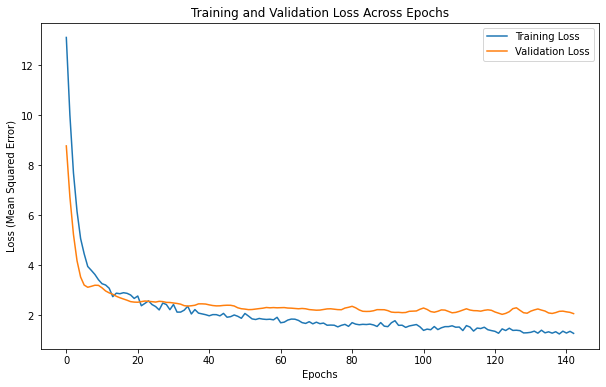

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=111)

# model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),  # Adjust dropout
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)  # Output layer
# ])
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.show()

In [92]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2587 - mae: 1.0833
Test MAE: 1.0689246654510498


In [93]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            # Select necessary columns
            player_row = player_row[required_columns + position_columns]

            # Convert to DataFrame with columns for scaler compatibility
            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            # Predict and collect
            player_prediction = model.predict(player_features)
            player_predictions.append(player_prediction[0])
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [94]:
#create a df team and prediction
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [95]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})
team_rankings_pred_df['Predicted'] = (team_rankings_pred_df['Predicted'].rank(method='min')).apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [96]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
0,Arsenal,1,1,0
3,Manchester City,1,1,0
12,Liverpool,1,2,1
11,Chelsea,1,1,0
7,West Bromwich Albion,2,2,0
13,Manchester United,2,1,-1
18,Swansea City,2,3,1
19,Tottenham Hotspur,2,2,0
15,Southampton,3,4,1
9,Wigan Athletic,3,5,2


## Player swap
#### van Persie, Robin -> Mackie, Jamie

In [97]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    
    # Special case swapping for Manchester United and Queens Park Rangers
    if team == 'Manchester United' and 'van Persie, Robin' in players:
        players = [player if player != 'van Persie, Robin' else 'Mackie, Jamie' for player in players]
    elif team == 'Queens Park Rangers' and 'Mackie, Jamie' in players:
        players = [player if player != 'Mackie, Jamie' else 'van Persie, Robin' for player in players]

    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            # Select necessary columns
            player_row = player_row[required_columns + position_columns]

            # Convert to DataFrame with columns for scaler compatibility
            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            # Predict and collect
            player_prediction = model.predict(player_features)
            player_predictions.append(player_prediction[0])
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [98]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [99]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})
team_rankings_pred_df['Predicted'] = (team_rankings_pred_df['Predicted'].rank(method='min')).apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [100]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
0,Arsenal,1,1,0
3,Manchester City,1,1,0
12,Liverpool,1,2,1
11,Chelsea,1,1,0
7,West Bromwich Albion,2,2,0
13,Manchester United,2,1,-1
18,Swansea City,2,3,1
19,Tottenham Hotspur,2,2,0
15,Southampton,3,4,1
9,Wigan Athletic,3,5,2


## More data as input

In [ ]:
def zones(matrix):
    

## MLS data interpretation

In [3]:
MLS_df = pd.read_excel('/Users/luisalawson/Downloads/MLS-Opta.xlsx')

In [127]:
PL_df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [4]:
MLS_df.drop(labels=['competition_name', 'competition_id'], axis=1, inplace=True)

In [5]:
MLS_df.rename(columns={'id': 'match_id', 'id.1': 'id'}, inplace=True)

In [6]:
MLS_df

,season_id,match_id,home_team_name,home_team_id,away_team_name,away_team_id,id,event_id,team_id,player_id,...,sec,x,y,date,time,type,description,outcome,playerName,playerPosition
0,2013,484772,Vancouver Whitecaps,1708,Toronto FC,2077,1333745792,1,1708,-99999,...,0,0.0,0.0,2013-03-02,22:32:24,34,Team set up,1,NotSpecified,NotSpecified
1,2013,484772,Vancouver Whitecaps,1708,Toronto FC,2077,426524759,1,2077,-99999,...,0,0.0,0.0,2013-03-02,22:46:51,34,Team set up,1,NotSpecified,NotSpecified
2,2013,484772,Vancouver Whitecaps,1708,Toronto FC,2077,846865551,2,1708,-99999,...,0,0.0,0.0,2013-03-02,23:42:45,32,Start,1,NotSpecified,NotSpecified
3,2013,484772,Vancouver Whitecaps,1708,Toronto FC,2077,163692331,2,2077,-99999,...,0,0.0,0.0,2013-03-02,23:42:46,32,Start,1,NotSpecified,NotSpecified
4,2013,484772,Vancouver Whitecaps,1708,Toronto FC,2077,868517532,3,2077,140123,...,0,50.0,50.0,2013-03-02,23:42:46,1,Pass,1,Kyle Bekker,Midfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567289,2013,733006,Sporting Kansas City,421,Real Salt Lake,1899,495808140,989,1899,-99999,...,17,0.0,0.0,2013-12-08,00:16:51,30,End,1,NotSpecified,NotSpecified
567290,2013,733006,Sporting Kansas City,421,Real Salt Lake,1899,142093035,990,1899,-99999,...,0,0.0,0.0,2013-12-08,00:18:33,30,End,1,NotSpecified,NotSpecified
567291,2013,733006,Sporting Kansas City,421,Real Salt Lake,1899,984890595,991,1899,-99999,...,0,0.0,0.0,2013-12-08,00:18:33,37,Collection End,1,NotSpecified,NotSpecified
567292,2013,733006,Sporting Kansas City,421,Real Salt Lake,1899,1023733865,1106,421,-99999,...,0,0.0,0.0,2013-12-08,00:18:34,30,End,1,NotSpecified,NotSpecified


In [7]:
MLS_df.loc[MLS_df['playerName'] == 'NotSpecified', ['playerName', 'playerPosition']] = ''

In [12]:
MLS_df['playerName'].value_counts()

playerName
                      8425
Aurelien Collin       3431
Javier Morales        3335
Kyle Beckerman        3301
Michael Harrington    3296
                      ... 
Michael Nanchoff         8
Armando Moreno           6
Brenton Griffiths        4
Jimmy Medranda           3
Corben Bone              1
Name: count, Length: 511, dtype: int64

In [15]:
MLS_df.loc[MLS_df['playerName'].isin(['NotSpecified', 'NotFound']), ['playerName', 'playerPosition']] = ''

In [16]:
MLS_df['playerName'].value_counts()

playerName
                      8473
Aurelien Collin       3431
Javier Morales        3335
Kyle Beckerman        3301
Michael Harrington    3296
                      ... 
Michael Nanchoff         8
Armando Moreno           6
Brenton Griffiths        4
Jimmy Medranda           3
Corben Bone              1
Name: count, Length: 510, dtype: int64

In [17]:
MLS_df.to_csv('/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data/MLS_df.csv', index=False)